# Task 1

---

# Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

## Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [31]:
# Web Scraping and Data Processing
import requests
from bs4 import BeautifulSoup

# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Text Processing and Visualization
import re

import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import ngrams, bigrams
from nltk.probability import FreqDist
import nltk.collocations as collocations

from wordcloud import WordCloud, STOPWORDS

# Machine Learning and Natural Language Processing
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews  = [] # create an empty list to collect all reviews
stars = [] # create an empty list to collect rating stars
date = [] # create an empty list to collect date
country = [] # create an empty list to collect country the reviewer is from

for i in range(1, pages + 1):
    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    
    # Reviews
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
        
    # Rating stars
    for para in parsed_content.find_all("div", {"class": "rating-10"}):
        try:
            stars.append(para.span.text)
        except:
            print(f"Error on page {i}")
            stars.append("None")
            
    # Date
    for para in parsed_content.find_all("time"):
        date.append(para.get_text())
        
    # Country
    for para in parsed_content.find_all("h3"):
        country.append(para.span.next_sibling.lower())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [3]:
# Fix bug, make the reviews, stars, date, and country arrays have the same number of elements.
stars = stars[:1000] 
reviews = reviews[:1000]
date = date[:1000]
country = country[:1000]

df = pd.DataFrame({"reviews":reviews,"stars": stars, "date":date, "country": country})

df.head()

,reviews,stars,date,country
0,✅ Trip Verified | Absolutely horrible airline....,\n\t\t\t\t\t\t\t\t\t\t\t\t\t5,23rd June 2023,(united states)
1,✅ Trip Verified | Having experienced delays a...,1,22nd June 2023,(united states)
2,✅ Trip Verified | Travelled to Heathrow to Kal...,1,20th June 2023,(united kingdom)
3,Not Verified | This flight failed at every le...,7,20th June 2023,(united kingdom)
4,Not Verified | Beware of British Airways and ...,1,19th June 2023,(united states)


In [4]:
df.shape

(1000, 4)

In [5]:
# Save the raw DataFrame to new csv file
df.to_csv("./data/BA_reviews.csv")

Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

## Text Preprocessing

In [6]:
df = pd.read_csv('./data/BA_reviews.csv')

df = df.drop(columns=["Unnamed: 0"])
df['verified'] = df.reviews.str.contains("Trip Verified") # check if user comments is verified
df['country'] = df['country'].str.replace('(', '').str.replace(')', '').str.title()

df.head()

,reviews,stars,date,country,verified
0,✅ Trip Verified | Absolutely horrible airline....,5,23rd June 2023,United States,True
1,✅ Trip Verified | Having experienced delays a...,1,22nd June 2023,United States,True
2,✅ Trip Verified | Travelled to Heathrow to Kal...,1,20th June 2023,United Kingdom,True
3,Not Verified | This flight failed at every le...,7,20th June 2023,United Kingdom,False
4,Not Verified | Beware of British Airways and ...,1,19th June 2023,United States,False


In [7]:
lemma = WordNetLemmatizer()

reviews_data = df.reviews.str.replace("✅ Trip Verified \|", "", regex=True)
reviews_data = reviews_data.str.replace("Not Verified \|", "", regex=True)

corpus = [] # create an empty list to collect cleaned data corpus

# loop through each review, remove punctuations, lower case it, join it and add it to corpus
for rev in reviews_data:
    rev = re.sub('[^a-zA-Z]',' ', rev)
    rev = rev.lower()
    rev = rev.split()
    rev = [lemma.lemmatize(word) for word in rev if word not in set(stopwords.words("english"))]
    rev = " ".join(rev)
    corpus.append(rev)
    
# Add the corpus to the original dataframe
df['corpus'] = corpus
df.head()

,reviews,stars,date,country,verified,corpus
0,✅ Trip Verified | Absolutely horrible airline....,5,23rd June 2023,United States,True,absolutely horrible airline communication terr...
1,✅ Trip Verified | Having experienced delays a...,1,22nd June 2023,United States,True,experienced delay cancellation departing usa e...
2,✅ Trip Verified | Travelled to Heathrow to Kal...,1,20th June 2023,United Kingdom,True,travelled heathrow kalamata return journey day...
3,Not Verified | This flight failed at every le...,7,20th June 2023,United Kingdom,False,flight failed every level delayed arrived dest...
4,Not Verified | Beware of British Airways and ...,1,19th June 2023,United States,False,beware british airway marketing make believe f...


In [8]:
from dateutil.parser import parse
df['date'] = df['date'].apply(lambda x: parse(x, fuzzy=True)) # change date format

df.date.head()

0   2023-06-23
1   2023-06-22
2   2023-06-20
3   2023-06-20
4   2023-06-19
Name: date, dtype: datetime64[ns]

In [9]:
# Save the cleaned DataFrame to new csv file
df.to_csv("./data/cleaned-BA-reviews.csv")

## Exploratory Data Analysis

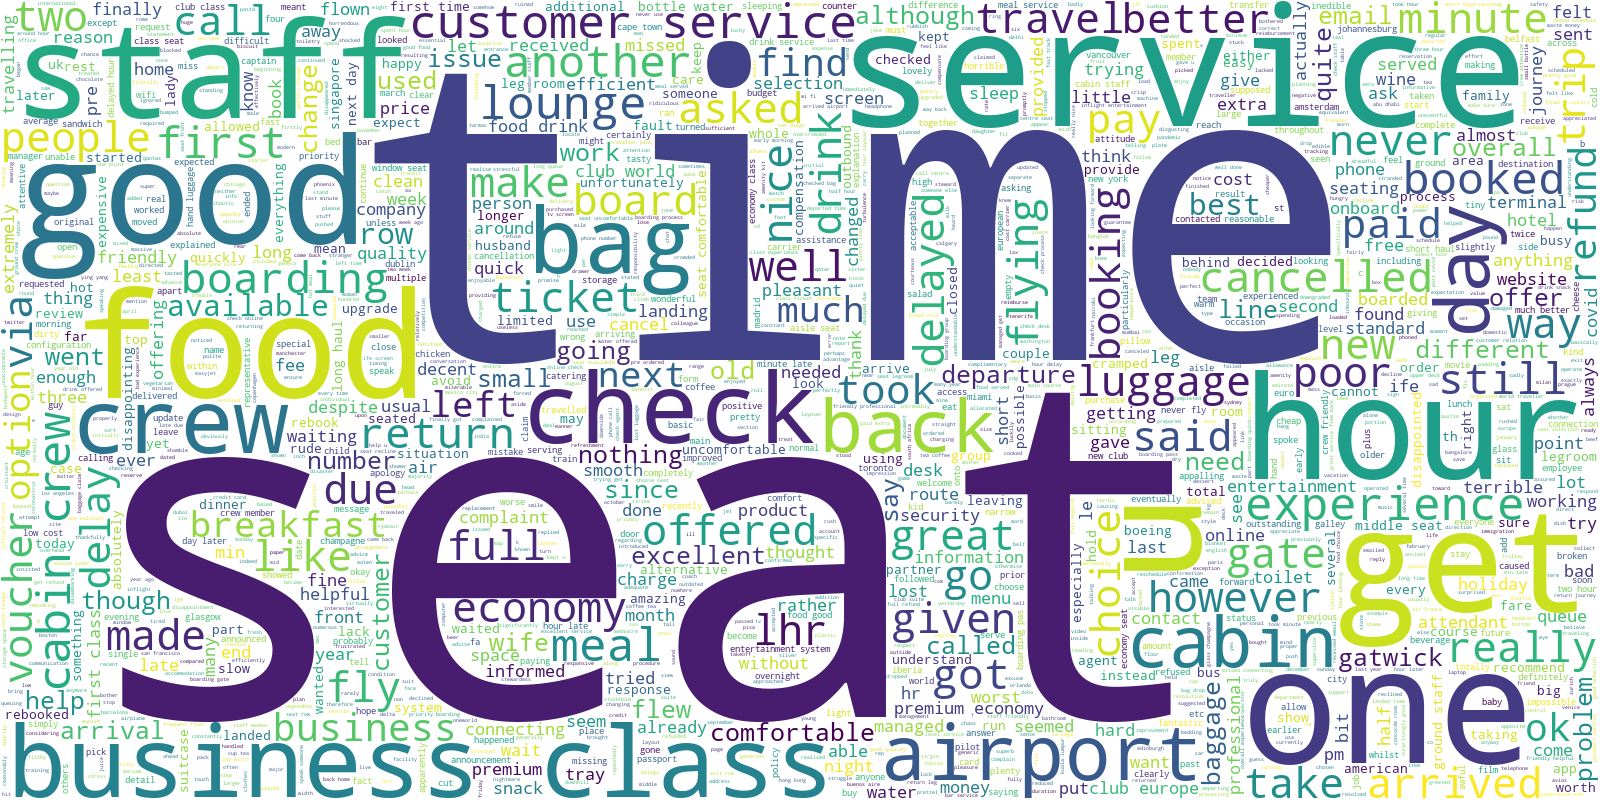

In [32]:
df = pd.read_csv("./data/cleaned-BA-reviews.csv")

# Join the different processed titles together.
long_string = ','.join(list(df['corpus'].values))

# List of stopwords that won't affect analyzis
stopwords = set(stopwords.words('english'))
stopwords.update(["ba","flight", "british","airway", "airline","plane", "told","also","passenger", "london", "heathrow", "aircraft", "could","even", "would"])

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, width=1600, height=800, contour_width=3, contour_color='steelblue', stopwords=stopwords)

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

### Stars Analysis

In [11]:
df.stars.describe()

count    1000.000000
mean        4.299000
std         3.307649
min         1.000000
25%         1.000000
50%         3.000000
75%         8.000000
max        10.000000
Name: stars, dtype: float64

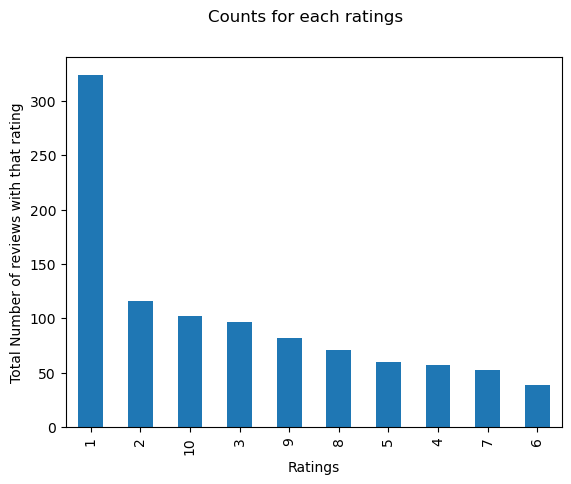

In [12]:
# Graph showing total counts for each rating
df.stars.value_counts().plot(kind="bar")
plt.xlabel("Ratings")
plt.ylabel("Total Number of reviews with that rating")
plt.suptitle("Counts for each ratings")
plt.show()

In [13]:
# Dataframe shows total counts and percentage values of each count
df_ratings = pd.DataFrame(df['stars'].value_counts())
df_ratings['pct_values'] = df_ratings['count'].values / df_ratings['count'].values.sum() * 100

df_ratings

,count,pct_values
stars,,
1,324,32.4
2,116,11.6
10,102,10.2
3,97,9.7
9,82,8.2
8,71,7.1
5,60,6.0
4,57,5.7
7,52,5.2


### Country Analysis

In [14]:
# Number of countries BA recieved the reviews from
print(f"{len(df.country.unique())} unique countries")

54 unique countries


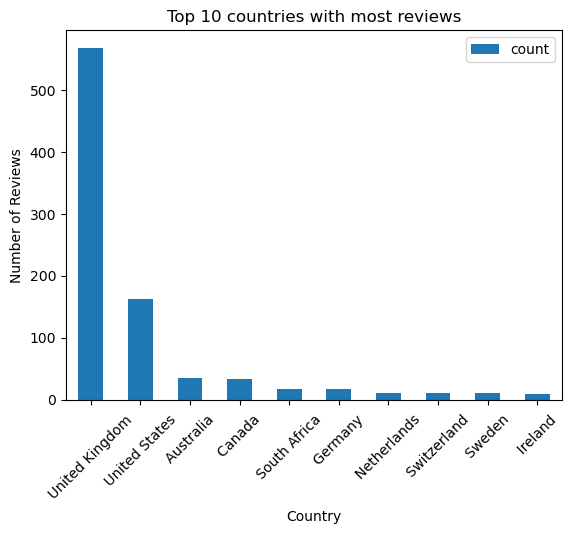

In [15]:
df_countries = pd.DataFrame(df['country'].value_counts().head(10))

df_countries.plot(kind="bar")
plt.title("Top 10 countries with most reviews")
plt.xlabel("Country")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.show()

## Word Frequency

In [16]:
# Split the text of all reviews into a list of words
words = long_string.split(" ")

# Remove stop words and certain words that won't be used to determine the positive or negative sentiment
stopwords = text.ENGLISH_STOP_WORDS.union(['flight', 'ba', "passenger","u", "london","airway","british","airline",\
                                           "heathrow","plane","lhr","review"])

new_words = [word for word in words if word not in stopwords]

nlp_words = FreqDist(new_words).most_common(20)

# Create a Dataframe of these word and its frequencies
all_fdist = pd.Series(dict(nlp_words))
all_fdist

seat        920
service     738
time        592
hour        524
crew        477
food        474
class       414
good        414
cabin       405
staff       390
business    372
check       339
customer    315
day         276
bag         261
economy     257
drink       254
meal        244
boarding    242
airport     233
dtype: int64

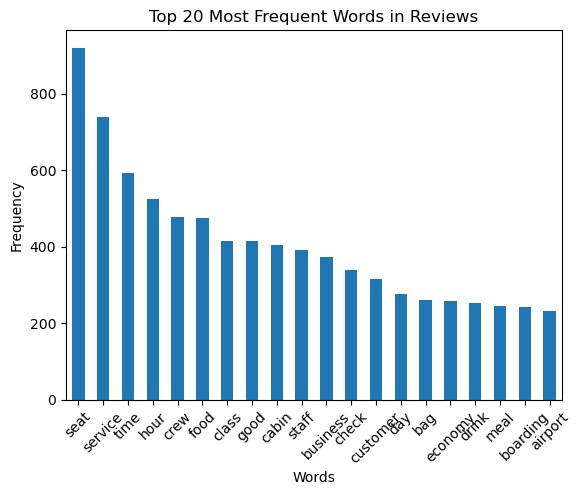

In [17]:
# Graph shows top 20 most frequent words in reviews
all_fdist.plot(kind="bar")
plt.title("Top 20 Most Frequent Words in Reviews")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

### Word Frequency with N-gram

<Axes: >

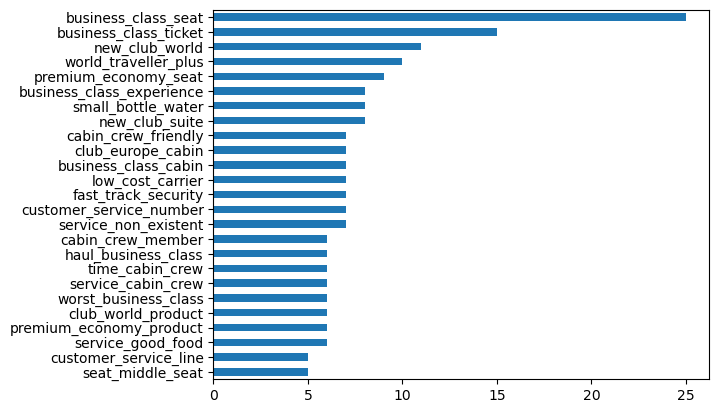

In [18]:
def get_freq_dist(words, n):
    ngram = ngrams(words, n) # generate ngrams
    ngram_fd = FreqDist(ngram).most_common(25) # create FreqDist
    ngram_joined = {'_'.join(k):v for k,v in sorted(ngram_fd, key=lambda item: item[1])} # Join bigram tokens with '_' + maintain sorting
    
    ngram_freqdist = pd.Series(ngram_joined) # Convert to Pandas series for easy plotting
    ax = ngram_freqdist.plot(kind = 'barh')
    return ax

get_freq_dist(new_words, 3)

In [19]:
'''
Group the reviews based on ratings:

    Ratings 1-3 are bad reviews, 
    Ratings 4-7 are average/good experience,
    Ratings 8-10 indicates a great experience.
'''
ratings_1_3 = df[df['stars'].isin([1, 2, 3])]
ratings_4_7 = df[df['stars'].isin([4, 5, 6, 7])]
ratings_8_10 = df[df['stars'].isin([8, 9, 10])]

reviews_1_3 = " ".join(ratings_1_3.corpus)
reviews_4_7 = " ".join(ratings_4_7.corpus)
reviews_8_10 = " ".join(ratings_8_10.corpus)

#split the text of all reviews into a list of words
words_1_3 = reviews_1_3.split(" ")
words_4_7 = reviews_4_7.split(" ")
words_8_10 = reviews_8_10.split(" ")

<Axes: >

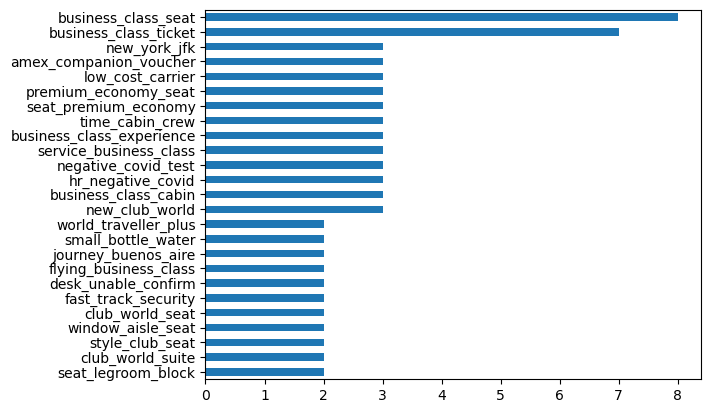

In [20]:
new_words_8_10 = [word for word in words_8_10 if word not in stopwords]

get_freq_dist(new_words_8_10, 3)

<Axes: >

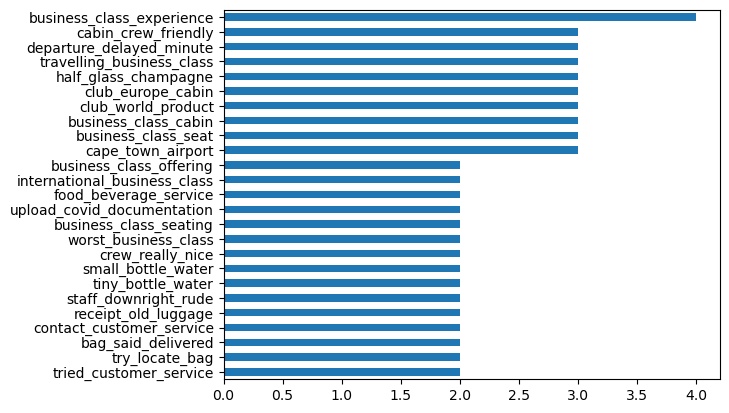

In [21]:
new_words_4_7 = [word for word in words_4_7 if word not in stopwords]

get_freq_dist(new_words_4_7, 3)

<Axes: >

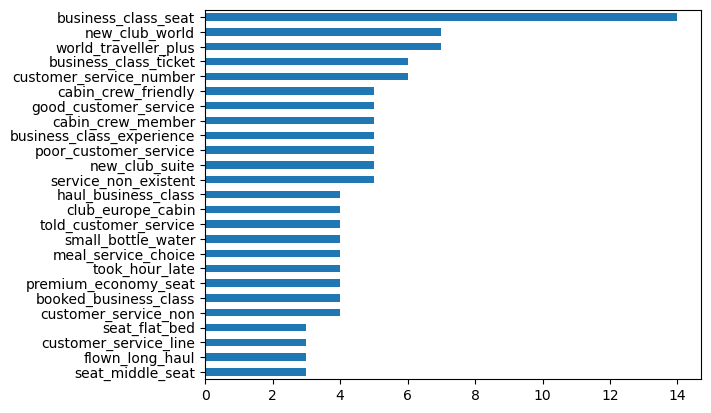

In [22]:
new_words_1_3 = [word for word in words_1_3 if word not in stopwords]

get_freq_dist(new_words_1_3, 3)

### Topic Modeling (LDA)

In [23]:
# Create an object of count vectorizer
vect = CountVectorizer()

# Apply transformation
tf = vect.fit_transform(df.corpus).toarray()
tf_feature_names = vect.get_feature_names_out()

In [25]:
# Declare the number of topics
number_of_topics = 5

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

# Fit the term frequency data to the model
model.fit(tf)

# Create empty dictionary to store key value pair of topic number and its weights
topic_dict = {}

# loop through model components 
for topic_idx, topic in enumerate(model.components_):
    topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(tf_feature_names[i])
            for i in topic.argsort()[:-10 - 1:-1]]
    topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
            for i in topic.argsort()[:-10 - 1:-1]]
    
df_topic = pd.DataFrame(topic_dict)
df_topic

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights
0,flight,382.8,flight,972.9,flight,143.8,seat,701.5,ba,42.7
1,crew,313.4,ba,557.8,ba,67.3,flight,552.6,seat,34.7
2,good,260.7,hour,312.0,time,49.7,service,280.9,flight,32.0
3,cabin,239.4,customer,297.9,lounge,48.4,ba,275.0,one,25.3
4,ba,233.2,service,256.4,good,46.8,class,242.3,crew,22.3
5,food,210.8,london,255.9,staff,44.8,economy,217.8,make,21.1
6,time,170.3,british,233.8,service,44.2,business,216.5,way,19.5
7,service,166.5,airway,231.1,food,41.8,food,198.5,service,15.0
8,london,136.7,day,226.7,london,41.0,london,180.2,time,14.7
9,meal,121.0,time,224.1,aircraft,39.1,hour,154.2,really,13.0
